In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)})
plt.rc('figure', figsize=(20, 10))
import numpy as np
import utils;reload(utils)
from utils import *
from keras.layers import Merge, Permute
import pdb
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import rankdata

In [62]:
def f1(p, r):
    return 6 * p * r / (5 * r + p)
def f2(p, r):
    return 5 * p * r / (3 * p + 2 * r)

In [ ]:
data_dir = 'data_new/'
action_cate8 = pd.read_csv(data_dir+"train/action_type_valid.csv", parse_dates=["date"])
users = pd.read_csv(data_dir+"JData_User.csv", encoding='gbk')

# pos04 = pd.read_csv("data/train/positive04.csv", parse_dates=["time_x", "time_y"])
# pos03 = pd.read_csv("data/train/positive03.csv", parse_dates=["time_x", "time_y"])
# all_pos = pd.concat((pos03, pos04))

In [ ]:
all_pos = pd.read_csv(data_dir+"train/positive_valid.csv", parse_dates=["date_x", "date_y"])

In [ ]:
negtive = pd.read_csv(data_dir+"train/negative_valid.csv", 
    parse_dates=["date_x", "date_y"], header=0)

In [ ]:
cv_negative = pd.read_csv(data_dir+"train/cv_negative_valid.csv", 
    parse_dates=["date_x", "date_y"], header=0)

In [ ]:
pos_and_neg = pd.concat((all_pos, negtive))
# pos_and_neg = all_pos

In [ ]:
buy_train = pos_and_neg[pos_and_neg.date_x < '20160411']
buy_cv = pos_and_neg[pos_and_neg.date_x >= '20160411']
buy_cv = pd.concat((buy_cv, cv_negative))

In [63]:
items = np.hstack((np.array([0]), action_cate8.sku_id.unique()))

users = action_cate8.user_id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
itemid2idx = {o:i for i,o in enumerate(items)}

n_users = len(users)
n_items = len(items)
n_factors = 50
n_users, n_items

(50504, 3463)

In [64]:
save_array(data_dir+'users', users)

In [65]:
save_array(data_dir+'products', items)

In [66]:
targets = action_cate8[action_cate8.action_type_4 > 0].sku_id.unique()
targetid2idx = {o:i for i,o in enumerate(targets)}
n_targets = len(targets)
n_targets

782

In [67]:
total_days = 10
days = 10
top_skus = 10
filter_day = 3
filter_sku = 2
days_offset = total_days-days

type_select = [1,2,3,5,6,7,8,9,10,11,12]
type_select_map = range(2, buy_cnn2d_trn.shape[-1])#[i-1+2 for i in type_select]
type_select_count = len(type_select_map)

In [68]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [69]:
user_in, user_emb = embedding_input('user_in', n_users, n_factors, 1e-4)
item_in, it = embedding_input('item_in', n_items, n_factors, 1e-4)

In [ ]:
sku_acc_by_day = action_cate8.groupby(['sku_id', 'date'], as_index=False).sum()
del sku_acc_by_day['user_id']
del sku_acc_by_day['active_users']
del sku_acc_by_day['user_count_for_sku']

In [70]:
sku_acc_by_day.head(2)

,sku_id,date,action_type_1,action_type_2,action_type_3,action_type_4,action_type_5,action_type_6
0,18,2016-03-09,2.0,0.0,0.0,0.0,0.0,2.0
1,95,2016-03-01,2.0,0.0,0.0,0.0,0.0,2.0


In [71]:
buy_train.head(2)

,action_type_1,action_type_2,action_type_3,action_type_4,action_type_5,action_type_6,active_users,date_x,date_y,sku_id_x,sku_id_y,user_count_for_sku,user_id,window_end,window_start
0,8.0,0.0,0.0,0.0,0.0,0.0,35353,2016-03-11,2016-03-04,103652,14163,238,231912.0,20160311,20160301
1,0.0,0.0,1.0,0.0,0.0,0.0,35353,2016-03-11,2016-03-04,103652,84409,155,231912.0,20160311,20160301


## 构造训练集

In [39]:
buy_cnn2d_trn, buy_cnn2d_trn_label = create_2dcnn_dataset(pd.merge(buy_train, 
        sku_acc_by_day, left_on = ['sku_id_y', 'date_y'], right_on=['sku_id', 'date']))

buy_cnn2d_cv, buy_cnn2d_cv_label = create_2dcnn_dataset(pd.merge(buy_cv, 
        sku_acc_by_day, left_on = ['sku_id_y', 'date_y'], right_on=['sku_id', 'date']))

In [40]:
save_array(data_dir+'buy_cnn2d_trn', buy_cnn2d_trn)
save_array(data_dir+'buy_cnn2d_trn_label', buy_cnn2d_trn_label)
save_array(data_dir+'buy_cnn2d_cv', buy_cnn2d_cv)
save_array(data_dir+'buy_cnn2d_cv_label', buy_cnn2d_cv_label)

In [ ]:
buy_cnn2d_trn = load_array(data_dir+'buy_cnn2d_trn')
buy_cnn2d_trn_label = load_array(data_dir+'buy_cnn2d_trn_label')
buy_cnn2d_cv = load_array(data_dir+'buy_cnn2d_cv')
buy_cnn2d_cv_label = load_array(data_dir+'buy_cnn2d_cv_label')

In [44]:
user_feature = utils.get_basic_user_feat(data_dir)

user_feature_dict = {}
for row in user_feature.values:
    user_feature_dict[row[0]] = row[1:]
# user_feature_dict

In [45]:
product_feat = utils.get_basic_product_feat(data_dir)

product_feat_dict = {}
for row in product_feat.values:
    product_feat_dict[row[0]] = list(row[3:])

product_feat_dict[0] = [0]*(product_feat.shape[1]-3)

In [46]:
buy_user_feat_trn = np.array([user_feature_dict[users[int(uidx)]] for uidx in buy_cnn2d_trn[:, 0, 0, 0]])
buy_user_feat_cv = np.array([user_feature_dict[users[int(uidx)]] for uidx in buy_cnn2d_cv[:, 0, 0, 0]])

## 使验证集的正负比例更接近于真实

在训练时使用正负比例接近的数据集，而验证时构造正负样本更接近于真实的比例，即负样本远大于正样本

In [47]:
buy_cnn2d_cv[buy_cnn2d_cv_label[:, 1] == 1].shape

(114, 10, 10, 47)

In [48]:
cv_neg = buy_cnn2d_cv[buy_cnn2d_cv_label[:, 1] == 0]
# cv_pos_unused, cv_pos = train_test_split(buy_cnn2d_cv[buy_cnn2d_cv_label[:, 1] == 1], test_size=len(cv_neg)/40)
cv_pos = buy_cnn2d_cv[buy_cnn2d_cv_label[:, 1] == 1]
buy_cnn2d_cv_imitate = np.vstack((cv_pos, cv_neg))
buy_cnn2d_cv_imitate_label = np.vstack((np.ones((len(cv_pos), 2)), np.zeros((len(cv_neg), 2))))

In [50]:
cv_pos.shape, cv_neg.shape#, cv_pos_unused.shape

((114, 10, 10, 47), (4403, 10, 10, 47))

In [51]:
buy_cnn2d_cv.shape

(4517, 10, 10, 47)

In [52]:
buy_user_feat_cv_imitate = np.array([user_feature_dict[users[int(uidx)]] for uidx in buy_cnn2d_cv_imitate[:, 0, 0, 0]])

## 行为热力图

/root/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


array([[28.0, 158.0, 183.0, 34.0, 67.0, 198.0, 47.0, 68.0, 1382.0, 160.0],
       [34.0, 188.0, 1373.0, 35.0, 158.0, 36.0, 772.0, 123.0, 731.0, 28.0],
       [34.0, 28.0, 68.0, 158.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [158, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [28.0, 34.0, 20.0, 124.0, 18.0, 322.0, 0.0, 0.0, 0.0, 0.0],
       [28.0, 211.0, 34.0, 105.0, 221.0, 35.0, 226.0, 0.0, 0.0, 0.0],
       [34.0, 1373.0, 18.0, 183.0, 189.0, 432.0, 226.0, 160.0, 221.0,
        1465.0],
       [28.0, 34.0, 158.0, 18.0, 211.0, 35.0, 183.0, 468.0, 284.0, 1373.0],
       [34.0, 18.0, 28.0, 1373.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=object)

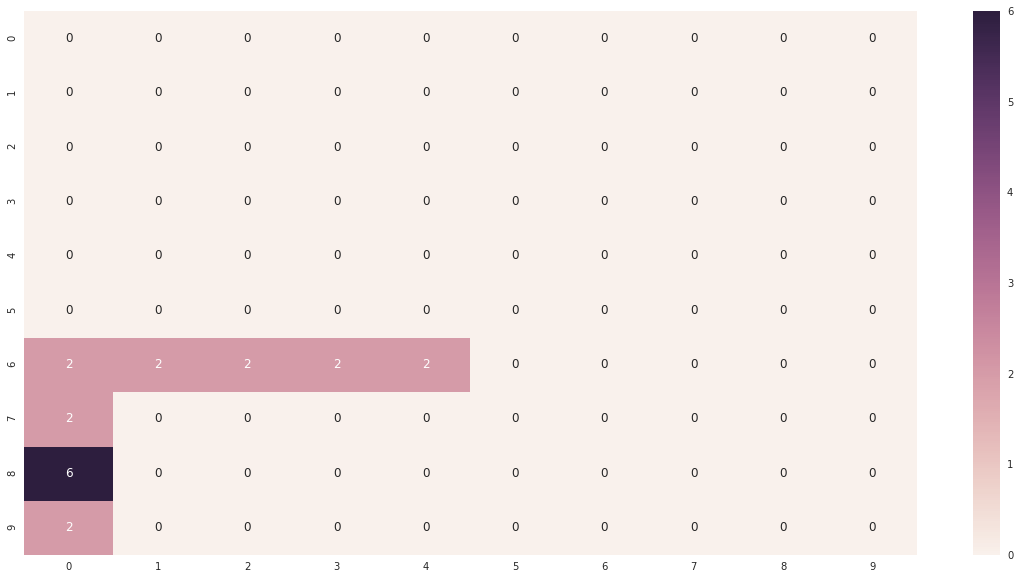

In [57]:
idx = 1308
sns.heatmap(sku_cnn2d_trn[idx, :, :, 12].astype(np.float32), annot=True)

buy_cnn2d_trn[idx, :, :, 1]

In [ ]:
for t in type_select_map:
    plt.figure()
    sns.plt.title(t-2+1)
    sns.heatmap(np.mean(cv_pos_unused[20:21, :, :, t], 0), annot=True)
# sku_cnn2d_trn[-1, :, :, 2]

## 购买商品集

In [54]:
sku_index = (buy_cnn2d_trn_label[:, 1] == 1)
sku_cv_index = (buy_cnn2d_cv_label[:, 1] == 1)
sku_cnn2d_trn, sku_cnn2d_trn_label = buy_cnn2d_trn[sku_index], buy_cnn2d_trn_label[sku_index]
sku_cnn2d_cv, sku_cnn2d_cv_label = buy_cnn2d_cv[sku_cv_index], buy_cnn2d_cv_label[sku_cv_index]

In [55]:
sku_user_feat_trn = np.array([user_feature_dict[users[int(uidx)]] for uidx in sku_cnn2d_trn[:, 0, 0, 0]])
sku_user_feat_cv = np.array([user_feature_dict[users[int(uidx)]] for uidx in sku_cnn2d_cv[:, 0, 0, 0]])

In [56]:
sku_user_feat_trn.shape, sku_user_feat_cv.shape

((3648, 16), (114, 16))

## 全连接神经网络

In [ ]:
trn, trn_label = create_dataset(train)
val, val_label = create_dataset(cv)

In [ ]:
def create_type():
    inp = Input(shape=(1,12), dtype='float32')
    return inp, Dense(24)(inp)

In [ ]:
type_in, tp = create_type()

In [ ]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [ ]:
ub = create_bias(user_in, n_users)
uit = create_bias(item_in, n_items)

## 训练购买商品模型

In [ ]:
# , cnn_trn_label[:, 1]
# , cnn_cv_label[:, 1]
# , sku_cnn2d_trn[:, 0, 0, 0]
# , sku_cnn2d_cv[:, 0, 0, 0]
epoch=4
conv2d_sku.compile(Adam(lr=0.01), loss=['sparse_categorical_crossentropy'],
           metrics=['accuracy'])
conv2d_sku.fit([sku_cnn2d_trn[:, days_offset:, :top_skus, 1:2], sku_cnn2d_trn[:, days_offset:, :top_skus, type_select_map], sku_user_feat_trn], [sku_cnn2d_trn_label[:, 0]], 
            batch_size=64, nb_epoch=epoch,
            validation_data=([sku_cnn2d_cv[:, days_offset:, :top_skus, 1:2], sku_cnn2d_cv[:, days_offset:, :top_skus, type_select_map], sku_user_feat_cv],
                             [sku_cnn2d_cv_label[:, 0]]))

## 训练是否购买模型

In [75]:
# , buy_cnn2d_trn[:, 0, 0, 0]
# , buy_cnn2d_cv[:, 0, 0, 0]
# buy_cnn2d_trn[:, (total_days-days):, :top_skus, 1:2], 
# buy_cnn2d_cv[:, (total_days-days):, :top_skus, 1:2], 
epoch = 2
conv2d_buy.compile(Adam(lr=0.01), loss=['sparse_categorical_crossentropy', 'binary_crossentropy'],
           metrics=['accuracy'], loss_weights=[0.01, 1.])
conv2d_buy.fit([buy_cnn2d_trn[:, days_offset:, :top_skus, 1:2], buy_cnn2d_trn[:, days_offset:, :top_skus, type_select_map].astype(np.float32), buy_user_feat_trn],
               [buy_cnn2d_trn_label[:, 0], buy_cnn2d_trn_label[:, 1]], 
            batch_size=512, nb_epoch=epoch,
            validation_data=([buy_cnn2d_cv_imitate[:, days_offset:, :top_skus, 1:2], buy_cnn2d_cv_imitate[:, days_offset:, :top_skus, type_select_map].astype(np.float32), buy_user_feat_cv_imitate],
                             [buy_cnn2d_cv_imitate_label[:, 0], buy_cnn2d_cv_imitate_label[:, 1]]), class_weight={0: 2., 1: 1.})

Train on 5790 samples, validate on 4517 samples
Epoch 1/2
5790/5790 [==============================] - 15s - loss: 0.8124 - sku_loss: 5.7271 - buy_loss: 0.7531 - sku_acc: 0.2798 - buy_acc: 0.5686 - val_loss: 0.9128 - val_sku_loss: 6.1474 - val_buy_loss: 0.8483 - val_sku_acc: 0.9134 - val_buy_acc: 0.1240

## 验证集上计算Score

In [76]:
cv_pred = conv2d_buy.predict([buy_cnn2d_cv_imitate[:, days_offset:, :top_skus, 1:2], buy_cnn2d_cv_imitate[:, days_offset:, :top_skus, type_select_map], buy_user_feat_cv_imitate])
cv_pred_df = pd.DataFrame(cv_pred[1])

In [81]:
# buy_cnn2d_cv[:, :, :, 1:2], 

# cv_pred_df = pd.DataFrame(np.argmax(cv_pred, 1))

cv_pred_df['user_id'] = [users[int(i)] for i in list(buy_cnn2d_cv_imitate[:, 0, 0, 0])]

cv_pred_df['buy'] = cv_pred_df.apply(lambda x: 1 if x[0] > 0.60 else 0, 1)

cv_pred_df['true'] = buy_cnn2d_cv_imitate_label[:, 1]
# cv_pred_df['true'] = [targets[i] for i in cnn_cv_label[:, 0]]

p = len(cv_pred_df[(cv_pred_df.buy == 1) & (cv_pred_df.true == 1)]) / float(len(cv_pred_df[cv_pred_df.buy==1]))
r = len(cv_pred_df[(cv_pred_df.buy == 1) & (cv_pred_df.true == 1)]) / float(len(cv_pred_df[cv_pred_df.true==1]))
# p = len(cv_pred_df[cv_pred_df.buy == cv_pred_df.true]) / float(len(cv_pred_df))
# r = len(cv_pred_df[cv_pred_df.buy == cv_pred_df.true]) / float(len(cv_pred_df))
p, r, f1(p, r)

(0.03279231533620404, 0.868421052631579, 0.03905582221053324)

## 构造测试集

In [41]:
test = load_array(data_dir+'test_cnn2d')

In [ ]:
test_df = pd.read_csv(data_dir+"train/test.csv", parse_dates=["date_x", "date_y"])

test, _ = create_2dcnn_dataset(pd.merge(test_df, 
        sku_acc_by_day, left_on = ['sku_id_y', 'date_y'], right_on=['sku_id', 'date']))

save_array(data_dir+'test_cnn2d', test)

In [ ]:
test_user_feat = np.array([user_feature_dict[users[int(uidx)]] for uidx in test[:, 0, 0, 0]])

## 对测试集做预测

In [ ]:
# , sku_cnn2d_trn[:, 0, 0, 0]
epoch = 4
sku_cnn2d_all = np.vstack((sku_cnn2d_trn, sku_cnn2d_cv))
sku_cnn2d_all_label = np.vstack((sku_cnn2d_trn_label, sku_cnn2d_cv_label))
sku_user_feat_all = np.vstack((sku_user_feat_trn, sku_user_feat_cv))
conv2d_sku.compile(Adam(lr=0.01), loss=['sparse_categorical_crossentropy'],
           metrics=['accuracy'])

conv2d_sku.fit([sku_cnn2d_all[:, days_offset:, :top_skus, 1:2], sku_cnn2d_all[:, days_offset:, :top_skus, type_select_map], sku_user_feat_all], [sku_cnn2d_all_label[:, 0]], 
            batch_size=64, nb_epoch=epoch)

In [ ]:
# , buy_cnn2d_all[:, 0, 0, 0]
# buy_cnn2d_all[:, days_offset:, :top_skus, 1:2], 
epoch = 4
buy_cnn2d_all = np.vstack((buy_cnn2d_trn, buy_cnn2d_cv))
buy_cnn2d_all_label = np.vstack((buy_cnn2d_trn_label, buy_cnn2d_cv_label))
buy_user_feat_all = np.vstack((buy_user_feat_trn, buy_user_feat_cv))
conv2d_buy.compile(Adam(lr=0.01), loss=['sparse_categorical_crossentropy', 'binary_crossentropy'],
           metrics=['accuracy'], loss_weights=[0.1, 1.])
conv2d_buy.fit([buy_cnn2d_all[:, days_offset:, :top_skus, 1:2], buy_cnn2d_all[:, days_offset:, :top_skus, type_select_map], buy_user_feat_all], 
               [buy_cnn2d_all_label[:, 0], buy_cnn2d_all_label[:, 1]], 
            batch_size=128, nb_epoch=epoch, class_weight={0: 2., 1: 1.})

In [ ]:
# test[:, 0, 0, 0]
# test[:, days_offset:, :top_skus, 1:2], 
buy_predicted = conv2d_buy.predict([test[:, days_offset:, :top_skus, 1:2], test[:, days_offset:, :top_skus, type_select_map], test_user_feat])

In [ ]:
# , test[:, 0, 0, 0]
sku_predicted = conv2d_sku.predict([test[:, days_offset:, :top_skus, 1:2], test[:, days_offset:, :top_skus, type_select_map], test_user_feat])

In [ ]:
test_pred_df = pd.DataFrame(buy_predicted[1])
test_pred_df['user_id'] = [int(users[int(i)]) for i in list(test[:, 0, 0, 0])]
test_pred_df['is_buy'] = test_pred_df.apply(lambda x: 1 if x[0] > 0.66 else 0, 1)
test_pred_df['sku_id'] = items[np.argmax(sku_predicted, 1)]
test_pred_df.is_buy.value_counts()

In [ ]:
result_df = test_pred_df[(test_pred_df.is_buy==1)&(test_pred_df.sku_id!=0)][['user_id', 'sku_id']]
print len(result_df)
result_df.to_csv("cnn2d.csv", index=False)
from IPython.display import FileLink
FileLink('cnn2d.csv')

In [72]:
create_2dcnn_dataset(pd.merge(buy_cv.tail(100), sku_acc_by_day, left_on = ['sku_id_y', 'date_y'], right_on=['sku_id', 'date']))

(array([[[[32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          ..., 
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
 
         [[32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          ..., 
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
 
         [[32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          ..., 
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
          [32614.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
 
         ..., 
         [

In [ ]:
def create_2dcnn_dataset(df):
    dual_group = df.groupby(['user_id', 'sku_id_x', 'window_start'])
    feature = []
    label = []
    for (uid, sid_buy, window_start), g in dual_group:
#         print time_buy
        sum_of_recent = g.sum()[['action_type_1_x',
                 'action_type_2_x',
                 'action_type_3_x',
                 'action_type_4_x',
                 'action_type_5_x',
                 'action_type_6_x']].values + 1 #近10天该用户对所有商品的交互总和
    
        window = []
        date_range = pd.date_range(start=str(window_start), periods=10, freq='D',closed='left')
#         print date_range
#         pdb.set_trace()
        for d in date_range:
            day_top10 = []
            window_day = d.strftime("%Y%m%d")
#             pdb.set_trace()
            # 取一天之中action最多的商品
            sku_of_day = g[g.date == window_day] #该用户在一天中所有商品交互记录
            
            if len(sku_of_day) == 0:
                top_skus = []
                sum_of_day = np.ones(6)
            else:
                sum_of_day = sku_of_day.sum()[['action_type_1_x',
                 'action_type_2_x',
                 'action_type_3_x',
                 'action_type_4_x',
                 'action_type_5_x',
                 'action_type_6_x']].values + 1 # 一天中该用户对所有商品的交互总和
                
                top_skus = sku_of_day.sort_values('action_type_1_x', ascending=False)\
                [['sku_id_y', 
                 'action_type_1_x',
                 'action_type_2_x',
                 'action_type_3_x',
                 'action_type_4_x',
                 'action_type_5_x',
                 'action_type_6_x',
                 'action_type_1_y',
                 'action_type_2_y',
                 'action_type_3_y',
                 'action_type_4_y',
                 'action_type_5_y',
                 'action_type_6_y',
                 'user_count_for_sku',
                 'active_users'
                 ]].values[:10] #一天中该用户排名前十的交互商品的交互量
                
            for i in range(10):
                try:
                    sku = top_skus[i]
                except:
                    sku = np.array([0] * 15)
                
                sku_id = int(itemid2idx[sku[0]])
                sku_action_count = sku[1:7] #该用户当天对该种商品的各类交互量
                sku_action_all = sku[7:13] #一天当中所有用户对某种商品的交互总和
#                 pdb.set_trace()
                idf = 1.0 / ((sku[13] + 1) / (sku[14] + 1))
                
                sku_feat_day = np.hstack((np.array([int(userid2idx[uid])]),
                           np.array([sku_id]),
                           np.array(product_feat_dict[sku[0]]),
                           sku_action_count,
                           np.array([sku_action_all[3] / (sku_action_all[i] + 1) for i in [0,1,2,4,5]]),
                                          #该种商品的购买数和各类交互量之比
                           sku_action_count / (sku_action_all + 1),
                           sku_action_count / (np.sum(sku_action_count) + 1.0), #对一种商品各种交互的占比
                           sku_action_count / sum_of_recent,
                           sku_action_count / sum_of_day * idf
                          ))
                    
                day_top10.append(sku_feat_day)
                
            window.append(day_top10)
        feature.append(window)
        label.append([itemid2idx[sid_buy], 0 if sid_buy == 0 else 1])
    return np.array(feature), np.array(label)

## 1D CNN

In [ ]:
conv_item_model = Sequential([
    Embedding(n_items, 32, input_length=10, W_regularizer=l2(1e-4)),
    Dropout(0.25),
    BatchNormalization(),
    Convolution1D(32, 3, border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Convolution1D(32, 3, border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(100)
])
conv_item_model.summary()
conv_type_model = Sequential([
#     Dense(32, input_shape=(10, 12)),
#     Dropout(0.25),
    Convolution1D(32, 3, border_mode='same', activation='relu', input_length=10, input_shape=(10,6)),
    Dropout(0.2),
    MaxPooling1D(),
    Convolution1D(32, 3, border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(100)
])

conv_item_in = Input(shape=(10,), dtype='int64', name='conv_item_in')
conv_item = conv_item_model(conv_item_in)
# conv_item_emb = Embedding(n_items, 32, input_length=10, W_regularizer=l2(1e-4))(conv_item_in)

conv_type_in = Input(shape=(10,6), dtype='float32', name='conv_type_in')
conv_type = BatchNormalization()(conv_type_in)
conv_type = conv_type_model(conv_type_in)
# conv_type = Dense(32, input_shape=(10,12))(conv_type_in)

# out = Merge(mode='concat', concat_axis=2)([conv_item_emb, conv_type])
# graph = Model([conv_item_in, conv_type_in], out)

# conv1 = Sequential([
#     graph,
#     Convolution1D(20, 3, border_mode='same', activation='relu'),
#     Dropout(0.2),
#     MaxPooling1D(),
#     Flatten(),
#     Dense(100, activation='relu'),
#     Dropout(0.7)
# ])
user_in, user_emb = embedding_input('user_in', n_users, n_factors, 1e-4)
user_emb = Flatten()(user_emb)

conv1 = merge([conv_item, conv_type, user_emb], mode='concat')

buy_x = Dense(1, activation='sigmoid', name="buy")(conv1)
sku_x = Dense(n_targets, activation='softmax', name="sku")(conv1)

# conv_all = Model([conv_item_in, conv_type_in, user_in], [sku_x, buy_x])
conv_all = Model([conv_item_in, conv_type_in, user_in], sku_x)
# conv_all.compile(Adam(lr=0.001), loss=['sparse_categorical_crossentropy', 'binary_crossentropy'],
#            metrics=['accuracy'], loss_weights=[0.01, 1.])
conv_all.compile(Adam(lr=0.001), loss=['sparse_categorical_crossentropy'],
           metrics=['accuracy'])

from keras.utils.visualize_util import plot
plot(conv_all, to_file='conv_all.png', show_shapes=True)
from IPython.display import Image
Image(filename='conv_all.png')


## 2D CNN For 购买商品预测

In [73]:
# n_items = 4028
conv2d_item_model = Sequential([
    Embedding(n_items, 10, input_length=days*top_skus, W_regularizer=l2(1e-4)),
    Reshape((days,top_skus,4)),
    Dropout(0.25),
    BatchNormalization(),
    Permute((3, 1, 2)),
    Convolution2D(4, filter_day, filter_sku, dim_ordering='th', border_mode='same', activation='relu'),
    Dropout(0.7),
    MaxPooling2D(),
    Convolution2D(4, filter_day, filter_sku, dim_ordering='th', border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling2D(),
    Flatten(),
    Dense(64)
])
conv2d_item_in = Input(shape=(days,top_skus,1), dtype='int64', name='conv2d_item_in')
conv2d_item = Flatten()(conv2d_item_in)
conv2d_item = conv2d_item_model(conv2d_item)

conv2d_type_model = Sequential([
#     Dense(32, input_shape=(type_select_count,days,top_skus), activation='relu'),
#     Dropout(0.25),
    Convolution2D(32, filter_day, filter_sku, dim_ordering='th', border_mode='valid', activation='relu', 
                  input_shape=(type_select_count,days,top_skus)),
    Dropout(0.7),
#     MaxPooling2D(),
    Convolution2D(32, filter_day, filter_sku, dim_ordering='th', border_mode='valid', activation='relu'),
    Dropout(0.2),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(100)
    Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.7),
#     BatchNormalization(),
#     Dense(128, activation='relu'),
#     Dropout(0.7),
#     BatchNormalization(),
#     Dense(64, activation='relu')
])

# conv_item_emb = Embedding(n_items, 32, input_length=10, W_regularizer=l2(1e-4))(conv_item_in)

conv2d_type_in = Input(shape=(days,top_skus,type_select_count), dtype='float32', name='conv2d_type_in')
conv2d_type = BatchNormalization()(conv2d_type_in)
conv2d_type = Permute((3, 1, 2))(conv2d_type)
conv2d_type = conv2d_type_model(conv2d_type)

# conv_type = Dense(32, input_shape=(10,12))(conv_type_in)

# out = Merge(mode='concat', concat_axis=2)([conv_item_emb, conv_type])
# graph = Model([conv_item_in, conv_type_in], out)

# conv1 = Sequential([
#     graph,
#     Convolution1D(20, 3, border_mode='same', activation='relu'),
#     Dropout(0.2),
#     MaxPooling1D(),
#     Flatten(),
#     Dense(100, activation='relu'),
#     Dropout(0.7)
# ])
# user_in, user_emb = embedding_input('user_in', n_users, n_factors, 1e-4)
# user_emb = Flatten()(user_emb)
user_feat_in = Input(dtype='float32', shape=(sku_user_feat_trn.shape[1],), name='user_feat_in')
user_feat_dense = Dense(64, activation='relu')(user_feat_in)

# conv2d = merge([conv2d_item, conv2d_type, user_emb], mode='concat')
conv2d = merge([conv2d_item, conv2d_type, user_feat_dense], mode='concat')
# conv2d = Dense(32, activation='relu')(conv2d)
# conv2d = Dropout(0.7)(conv2d)

buy_x = Dense(1, activation='sigmoid', name="buy")(conv2d)
sku_x = Dense(n_items, activation='softmax', name="sku")(conv2d)

# conv_all = Model([conv_item_in, conv_type_in, user_in], [sku_x, buy_x])
# conv2d_all = Model([conv2d_item_in, conv2d_type_in, user_in], sku_x)
conv2d_sku = Model([conv2d_item_in, conv2d_type_in, user_feat_in], sku_x)
# conv_all.compile(Adam(lr=0.001), loss=['sparse_categorical_crossentropy', 'binary_crossentropy'],
#            metrics=['accuracy'], loss_weights=[0.01, 1.])
conv2d_sku.compile(Adam(lr=0.001), loss=['sparse_categorical_crossentropy'],
           metrics=['accuracy'])

from keras.utils.visualize_util import plot
plot(conv2d_sku, to_file='conv2d_sku.png', show_shapes=True)
from IPython.display import Image
Image(filename='conv2d_sku.png')



ValueError: total size of new array must be unchanged

## 是否购买

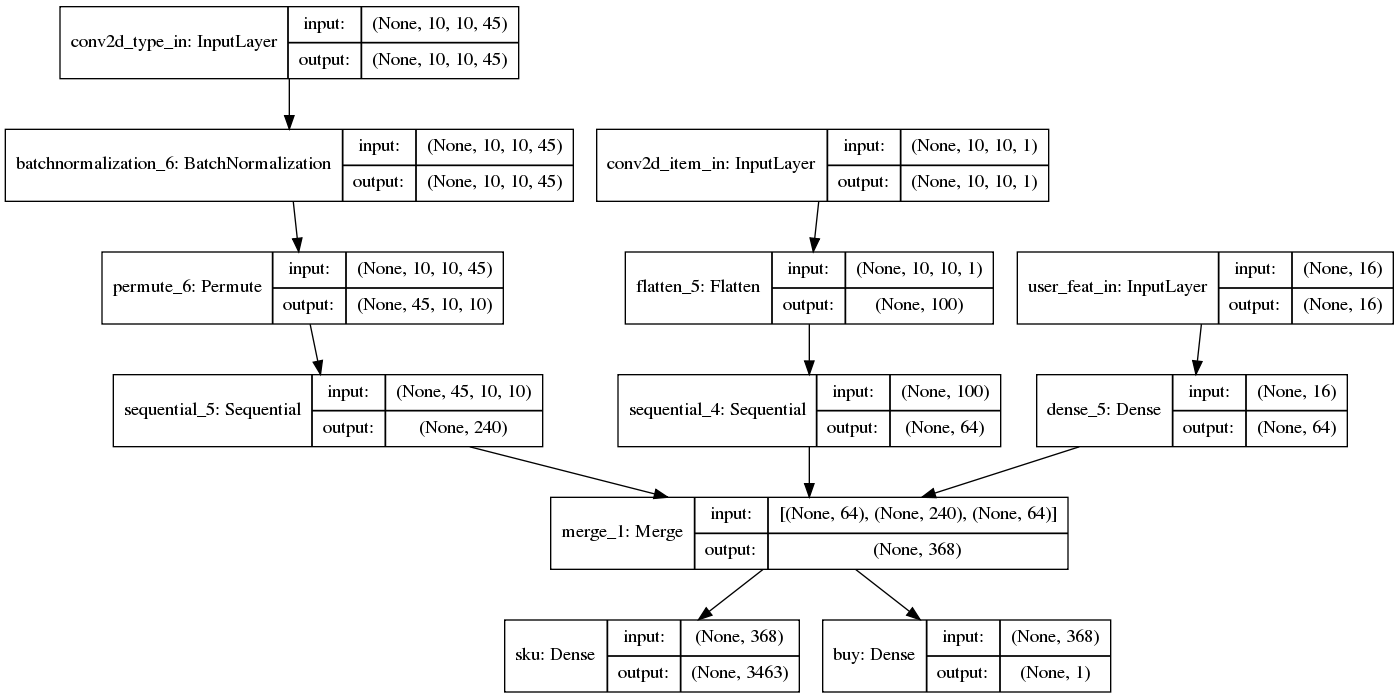

In [74]:
conv2d_item_model = Sequential([
    Embedding(n_items, 10, input_length=days*top_skus, W_regularizer=l2(1e-4)),
    Reshape((days,top_skus,10)),
    Dropout(0.25),
    BatchNormalization(),
    Permute((3, 1, 2)),
    Convolution2D(5, filter_day, filter_sku, dim_ordering='th', border_mode='same', activation='relu'),
    Dropout(0.7),
    MaxPooling2D(),
    Convolution2D(5, filter_day, filter_sku, dim_ordering='th', border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling2D(),
    Flatten(),
    Dense(64)
])
conv2d_item_in = Input(shape=(days,top_skus,1), dtype='int64', name='conv2d_item_in')
conv2d_item = Flatten()(conv2d_item_in)
conv2d_item = conv2d_item_model(conv2d_item)

conv2d_type_model = Sequential([
#     Dense(32, input_shape=(type_select_count,days,top_skus), activation='relu'),
#     Dropout(0.25),
    Convolution2D(5, filter_day, filter_sku, dim_ordering='th', border_mode='valid', activation='relu', 
                  input_shape=(type_select_count,days,top_skus)),
    Dropout(0.7),
#     MaxPooling2D(),
    Convolution2D(5, filter_day, filter_sku, dim_ordering='th', border_mode='valid', activation='relu'),
    Dropout(0.2),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(100)
    Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.7),
#     BatchNormalization(),
#     Dense(128, activation='relu'),
#     Dropout(0.7),
#     BatchNormalization(),
#     Dense(64, activation='relu')
])

# conv_item_emb = Embedding(n_items, 32, input_length=10, W_regularizer=l2(1e-4))(conv_item_in)

conv2d_type_in = Input(shape=(days,top_skus,type_select_count), dtype='float32', name='conv2d_type_in')
conv2d_type = BatchNormalization()(conv2d_type_in)
conv2d_type = Permute((3, 1, 2))(conv2d_type)
conv2d_type = conv2d_type_model(conv2d_type)

# conv_item_emb = Embedding(n_items, 32, input_length=10, W_regularizer=l2(1e-4))(conv_item_in)

conv2d_type_in = Input(shape=(days,top_skus,type_select_count), dtype='float32', name='conv2d_type_in')
conv2d_type = BatchNormalization()(conv2d_type_in)
conv2d_type = Permute((3, 1, 2))(conv2d_type)
conv2d_type = conv2d_type_model(conv2d_type)

# conv_type = Dense(32, input_shape=(10,12))(conv_type_in)

# out = Merge(mode='concat', concat_axis=2)([conv_item_emb, conv_type])
# graph = Model([conv_item_in, conv_type_in], out)

# conv1 = Sequential([
#     graph,
#     Convolution1D(20, 3, border_mode='same', activation='relu'),
#     Dropout(0.2),
#     MaxPooling1D(),
#     Flatten(),
#     Dense(100, activation='relu'),
#     Dropout(0.7)
# ])
# user_in, user_emb = embedding_input('user_in', n_users, n_factors, 1e-4)
# user_emb = Flatten()(user_emb)
user_feat_in = Input(dtype='float32', shape=(user_feature.shape[1] - 1,), name='user_feat_in')
user_feat_dense = Dense(64, activation='relu')(user_feat_in)

# conv2d = merge([conv2d_item, conv2d_type, user_emb], mode='concat')
conv2d = merge([conv2d_item, conv2d_type, user_feat_dense], mode='concat')
# conv2d = Dense(32, activation='relu')(conv2d)
# conv2d = Dropout(0.7)(conv2d)

buy_x = Dense(1, activation='sigmoid', name="buy")(conv2d)
sku_x = Dense(n_items, activation='softmax', name="sku")(conv2d)
# conv_all = Model([conv_item_in, conv_type_in, user_in], [sku_x, buy_x])
# conv2d_buy = Model([conv2d_item_in, conv2d_type_in, user_in], buy_x)
conv2d_buy = Model([conv2d_item_in, conv2d_type_in, user_feat_in], [sku_x, buy_x])
conv2d_buy.compile(Adam(lr=0.001), loss=['sparse_categorical_crossentropy', 'binary_crossentropy'],
           metrics=['accuracy'], loss_weights=[0.1, 1.])
# conv2d_buy.compile(Adam(lr=0.001), loss=['binary_crossentropy'],
#            metrics=['accuracy'])

from keras.utils.visualize_util import plot
plot(conv2d_buy, to_file='conv2d_buy.png', show_shapes=True)
from IPython.display import Image
Image(filename='conv2d_buy.png')